In [1024]:
import sympy as sym
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy
import time
import os
from IPython.display import display

class Billiard:
    # shape = "quartercircle", "circle"
    def __init__(self, shape, a1, a2, M0, V0) -> None:
        self.x1, self.x2 = sym.symbols("x1 x2")
        self.m1, self.m2 = sym.symbols("m1 m2", integer=True, nonzero=True)
        self.n1, self.n2 = sym.symbols("n1, n2", integer=True, nonzero=True)
        self.shape = shape
        self.a1 = a1
        self.a2 = a2
        self.M0 = M0
        self.V0 = V0
        
        self.phi_m = sym.sqrt(2.0/self.a1)*sym.sin(sym.pi * m1 * x1) * sym.sqrt(2.0/self.a2) * sym.sin(sym.pi * m2 *x2)
        self.phi_n = sym.sqrt(2.0/self.a1)*sym.sin(sym.pi * n1 * x1) * sym.sqrt(2.0/self.a2) * sym.sin(sym.pi * n2 *x2)

        # for calculating the wavefunction later
        self.phi = sym.lambdify([x1, x2, m1, m2], phi_m)

        self.generate_integer_pairs()

    ###################
    #     V_MATRIX    #
    ###################

    def analytic_integral(self):
        if self.shape == 'quartercircle':
            self.v_analytic = sym.integrate(self.phi_m*self.phi_n, (self.x2, sym.sqrt(1-self.x1**2), 1))
            self.v_analytic = sym.lambdify([self.x1, self.m1, self.m2, self.n1, self.n2], self.v_analytic)

    # numerical integral
    def vnm(self, m1_, m2_, n1_, n2_):
        if self.shape == 'quartercircle':
            return quad(lambda x: self.v_analytic(x, m1_, m2_, n1_, n2_), 0, 1)[0]

    def generate_v_matrix(self):
        # check if file already exists:
        foldername = "vmatrices"
        filename = "vmatrix_{}_M{}_V{}.txt".format(self.shape, int(self.M0), int(self.V0))

        if filename in os.listdir("vmatrices"):
            self.v_matrix = np.loadtxt(foldername + "/" + filename)
            print("V-matrix Imported")

        else:
            print("Generating V-matrix")
            start = time.time()

            self.v_matrix = np.zeros([self.M0,self.M0])
            for i,m in enumerate(self.pairs):

                # estimate remaining time
                if i== 0:
                    print("{}/{}\t ETR: tbd".format(i+1, self.M0))
                else:
                    elapsed = time.time() - start
                    time_remaining = sum([self.M0 - x for x in range(i, self.M0)])*elapsed / float(sum([self.M0 - x for x in range(i)]))
                    print("{}/{}\t ETR: {}:{:02d}".format(i+1, self.M0, int(time_remaining // 60), int(time_remaining%60)))

                for j,n in enumerate(self.pairs):
                    
                    if j >= i:
                        self.v_matrix[i,j] = self.vnm(m[0], m[1], n[0], n[1])
                    
                    # because v_matrix is symmetric
                    elif j < i:
                        self.v_matrix[i,j] = self.v_matrix[j, i]
            

            print("Finished generating V-matrix")

            # SAVE V MATRIX TO FILE!
            np.savetxt(foldername + "/" + filename, self.v_matrix)
            


    ####################
    #    HAMILTONIAN   #
    ####################

    def generate_hamiltonian(self):
        self.hamiltonian = np.zeros([self.M0, self.M0])

        for i,m in enumerate(self.pairs):
            self.hamiltonian[i, i] = np.pi ** 2 * ((m[0]/self.a1) ** 2 + (m[1]/self.a2) ** 2)

        self.hamiltonian = self.hamiltonian + V0 * self.v_matrix

        # calc eigenvals and vecs
        self.eigenvals, self.eigenvecs = np.linalg.eig(self.hamiltonian)

        self.eigenvecs = np.transpose(self.eigenvecs)
        # sort based on ascending eigenvals
        self.eigenvecs = np.array([vec for _, vec in sorted(zip(self.eigenvals, self.eigenvecs))])
    

    ####################
    #     PLOTTING     #
    ####################
    def evalute_wavefunction_grid(self, n, x_pixels, y_pixels):
        if self.shape == 'quartercircle':
            self.X1 = np.linspace(0, 1, x_pixels)
            self.X2 = np.linspace(0, 1, y_pixels)

            self.wavefunction = np.zeros([x_pixels, y_pixels])

            for i, x in enumerate(X1):
                for j, y in enumerate(X2):
                    self.wavefunction[i, j] = abs(self.psi(n, x,y))

    def plot_wavefunction(self, n, x_pixels, y_pixels):

        self.evalute_wavefunction_grid(n, x_pixels, y_pixels)

        padding = 5

        # plot quartercircle
        plt.plot(np.linspace(0,1,200)*x_pixels, y_pixels*np.sqrt(1-np.linspace(0,1,200)**2), color="black")
        plt.plot([0,0], [0,nx1], color="black")
        plt.plot([0,nx2], [0,0], color="black")

        # plot wavefuction
        plt.imshow(self.wavefunction, cmap='gray_r', origin="lower", interpolation="bicubic")
        plt.ylim([-padding,x_pixels + padding])
        plt.xlim([-padding,y_pixels + padding])
        plt.axis("off")

        plt.show()


    def plot_wavefunction3D(self, n, x_pixels, y_pixels):

        self.evalute_wavefunction_grid(n, x_pixels, y_pixels)

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        X, Y = np.meshgrid(self.X1, self.X2)
        ax.plot_surface(X,Y, self.wavefunction)
        fig.show()

        


    ####################
    # HELPER FUNCTIONS #
    ####################

    # generates list of i_max positive integer pairs
    def generate_integer_pairs(self):
        pair = np.array([1,1], dtype=int)

        odd = lambda x: x%2 == 1
        even = lambda x: x%2 == 0

        self.pairs = [copy.deepcopy(pair)]
        
        for _ in range(self.M0-1):
            if odd(pair[0]) and pair[1]==1 :
                pair += np.array([1,0])

            elif pair[0]==1 & even(pair[1]):
                pair += np.array([0,1])

            elif (odd(pair[0]) and even(pair[1])) or (even(pair[0]) and odd(pair[1])):
                pair += np.array([-1,1])

            elif (odd(pair[0]) and odd(pair[1])) or (even(pair[0]) and even(pair[1])):
                pair += np.array([1,-1])
            
            self.pairs.append(copy.deepcopy(pair))
        
    # returns nth wavefuntion at coordinate (x1_, x2_)
    def psi(self, n_, x1_, x2_):

        psi = 0
        # pairs not sorted because order in rows of eigenvecs is according to og arrangement
        for i, m in enumerate(self.pairs):
            psi += self.eigenvecs[n_][i] * self.phi(x1_, x2_, m[0], m[1])
        
        return psi


In [1025]:
QC = Billiard(shape='quartercircle', a1=1, a2=1, M0=400, V0=5e4)
QC.analytic_integral()

In [1027]:
QC.generate_v_matrix()
QC.generate_hamiltonian()

V-matrix Imported


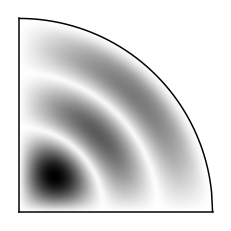

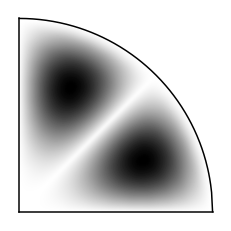

In [1029]:
QC.plot_wavefunction(5, 80, 80)
QC.plot_wavefunction(1, 80, 80)

In [722]:
x1, x2 = sym.symbols("x1 x2")
m1, m2 = sym.symbols("m1 m2", integer=True, nonzero=True)
n1, n2 = sym.symbols("n1, n2", integer=True, nonzero=True)
a1,a2 = sym.symbols("a1 a2", nonzero=True)

phi_m = 2*sym.sin(sym.pi * m1 * x1) * sym.sin(sym.pi * m2 *x2)
phi_n = 2*sym.sin(sym.pi * n1 * x1) * sym.sin(sym.pi * n2 *x2)

v2top = sym.integrate(phi_m*phi_n, (x2, sym.sqrt(1-x1**2), 1))
#v2bottom = sym.integrate(phi_m*phi_n, (x2, -1, sym.sqrt(1-x1**2)))

v2 = v2top.evalf()
v2 = sym.lambdify([x1, m1, m2, n1, n2], v2)


In [258]:
v2(0.4, 1, 1, 1, 1)

<string>:2: RuntimeWarning: divide by zero encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


array(0.00683121)

In [754]:
def vnm(m1, m2, n1, n2):
    return quad(lambda x: v2(x, m1, m2, n1, n2), 0, 1)[0]

In [755]:
vnm(1,1,2,2)

0.0948780163529595

In [279]:
def int_pair_list(i_max):
    pair = np.array([1,1], dtype=int)

    odd = lambda x: x%2 == 1
    even = lambda x: x%2 == 0

    
    pair_list = [copy.deepcopy(pair)]
    
    for _ in range(i_max):
        if odd(pair[0]) and pair[1]==1 :
            pair += np.array([1,0])

        elif pair[0]==1 & even(pair[1]):
            pair += np.array([0,1])

        elif (odd(pair[0]) and even(pair[1])) or (even(pair[0]) and odd(pair[1])):
            pair += np.array([-1,1])

        elif (odd(pair[0]) and odd(pair[1])) or (even(pair[0]) and even(pair[1])):
            pair += np.array([1,-1])
        
        pair_list.append(copy.deepcopy(pair))
    
    return pair_list


In [369]:
M0 = 400
V0 = 50000
v_matrix = np.zeros([M0,M0])

pairs = int_pair_list(M0)
#plt.plot([i[0] for i in pairs], [i[1] for i in pairs])
for i,m in enumerate(pairs[:M0]):
    for j,n in enumerate(pairs[:M0]):
        
        if j >= i:
            v_matrix[i,j] = vnm(m[0], m[1], n[0], n[1])
        
        # because v_matrix is symmetric
        elif j < i:
            v_matrix[i,j] = v_matrix[j, i]
    print(i+1, "/", M0)



1 / 400
2 / 400
3 / 400
4 / 400
5 / 400
6 / 400
7 / 400
8 / 400
9 / 400
10 / 400
11 / 400
12 / 400
13 / 400
14 / 400
15 / 400
16 / 400
17 / 400
18 / 400
19 / 400
20 / 400
21 / 400
22 / 400
23 / 400
24 / 400
25 / 400
26 / 400
27 / 400
28 / 400
29 / 400
30 / 400
31 / 400
32 / 400
33 / 400
34 / 400
35 / 400
36 / 400
37 / 400
38 / 400
39 / 400
40 / 400
41 / 400
42 / 400
43 / 400
44 / 400
45 / 400
46 / 400
47 / 400
48 / 400
49 / 400
50 / 400
51 / 400
52 / 400
53 / 400
54 / 400
55 / 400
56 / 400
57 / 400
58 / 400
59 / 400
60 / 400
61 / 400
62 / 400
63 / 400
64 / 400
65 / 400
66 / 400
67 / 400
68 / 400
69 / 400
70 / 400
71 / 400
72 / 400
73 / 400
74 / 400
75 / 400
76 / 400
77 / 400
78 / 400
79 / 400
80 / 400
81 / 400
82 / 400
83 / 400
84 / 400
85 / 400
86 / 400
87 / 400
88 / 400
89 / 400
90 / 400
91 / 400
92 / 400
93 / 400
94 / 400
95 / 400
96 / 400
97 / 400
98 / 400
99 / 400
100 / 400
101 / 400
102 / 400
103 / 400
104 / 400
105 / 400
106 / 400
107 / 400
108 / 400
109 / 400
110 / 400
111 / 40

In [370]:
# SAVE V MATRIX TO FILE!
with open("v.dat", "w") as o:
    for line in v_matrix:
        print("{} {}".format(line[0], line[1]), file=o)

In [651]:
H_matrix = np.zeros([M0, M0])

for i,m in enumerate(pairs[:M0]):
    H_matrix[i, i] = np.pi ** 2 * (m[0] ** 2 + m[1] ** 2)

H_matrix = H_matrix + V0 * v_matrix

# calc eigenvals and vecs
eigenvals, eigenvecs = np.linalg.eig(H_matrix)

eigenvecs = np.transpose(eigenvecs)
# sort based on ascending eigenvals
eigenvecs = np.array([vec for _, vec in sorted(zip(eigenvals, eigenvecs))])
# need to sort pairs based on eigenvals
pairs_sorted = np.array([pair for _, pair in sorted(zip(eigenvals, pairs))])


In [398]:
# 5.19 for M0 = 130
#sorted(np.sqrt(eigenvals))


In [400]:
phi = sym.lambdify([x1, x2, m1, m2], phi_m)

def psi(n, x1, x2):

    psi = 0
    # pairs not sorted because order in rows of eigenvecs is according to og arrangement
    for i, m in enumerate(pairs[:M0]):
        psi += eigenvecs[n][i] * phi(x1, x2, m[0], m[1])
    
    return psi


In [719]:
nx1 = 80
nx2 = 80

X1 = np.linspace(0, 1, nx1)
X2 = np.linspace(0, 1, nx2)

billiard = np.zeros([nx1, nx2])

for i, x in enumerate(X1):
    for j, y in enumerate(X2):
        billiard[i, j] = abs(psi(22, x,y))


        

(-5.0, 85.0, -5.0, 85.0)

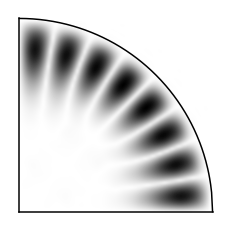

In [720]:
plt.plot(np.linspace(0,1,200)*nx1, nx2*np.sqrt(1-np.linspace(0,1,200)**2), color="black")
plt.plot([0,0], [0,nx1], color="black")
plt.plot([0,nx2], [0,0], color="black")

plt.imshow(billiard, cmap='gray_r', origin="lower", interpolation="bicubic")
plt.ylim([-5,nx1+5])
plt.xlim([-5,nx2+5])

plt.axis("off")

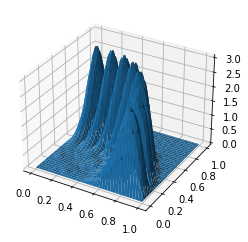

In [721]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(X1, X2)
ax.plot_surface(X,Y, billiard)

In [665]:
# area and perimeter
A  = np.pi/4
L = 2 + np.pi / 2

# multiply with area of billiard & use units like in paper
e_eigenvals = np.sort(eigenvals * A/(4*np.pi))

def weyl(E, A, L):
    return 1/(4*np.pi) * (A*E - L * np.sqrt(E))

def nE(Emax, E_list):
    # Returns count of entries in E_list smaller or equal to Emax
    count = 0
    for E in E_list:
        if E <= Emax:
            count += 1

    return count

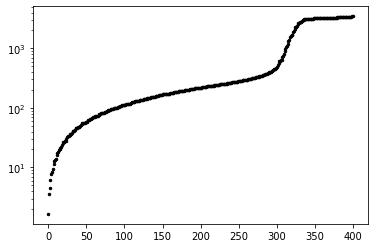

In [686]:
plt.scatter(range(len(e_eigenvals)), e_eigenvals, s=6, color="black")
plt.yscale("log")

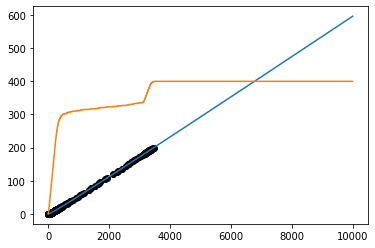

In [700]:

E_tilde = [weyl(E, A, L) for E in e_eigenvals]
plt.scatter(e_eigenvals, E_tilde, c="black")
plt.plot(range(10000), [weyl(i,A,L) for i in range(10000)])
plt.plot(range(10000), [nE(E, e_eigenvals) for E in range(10000)])
#plt.xlim([0,300])
#plt.ylim([-1,15])

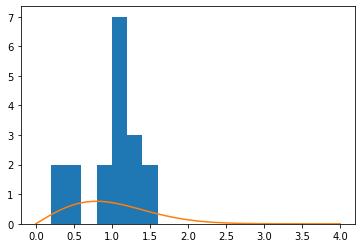

In [697]:
sn_tilde = [E_tilde[n+1] - E_tilde[n] for n in range(0, len(E_tilde)-1)]
sn = [(e_eigenvals[n+1] - e_eigenvals[n]) for n in range(0, len(e_eigenvals)-1)]

eigenvals = np.sort(eigenvals)
Ps = [min([eigenvals[i+1]- eigenvals[i], eigenvals[i] - eigenvals[i-1]]) for i in range(1,len(eigenvals) -1)]

mean = sum(Ps)/len(Ps)
plt.hist(np.sort(Ps), bins=[0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8])

Pgoe = lambda s: np.pi/2 * s * np.exp(-np.pi * s**2 / 4)

S = np.linspace(0, 4, 100)

plt.plot(S, [Pgoe(s) for s in S])

In [696]:
sum(sn)

17.67738695347963